In [2]:
import numpy as np  
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [50]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=80

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Indian Medicinal Leaves Image Datasets/Medicinal plant dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5945 files belonging to 40 classes.


In [10]:
class_names = dataset.class_names
len(class_names)

40

In [11]:
len(dataset)

186

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[ 8  6 38 15  3  5  8 21 17 30 29 10 12 25 31 11 37  3 10  8 30  4  9 15
 11 12 23  1 10  4 13 29]


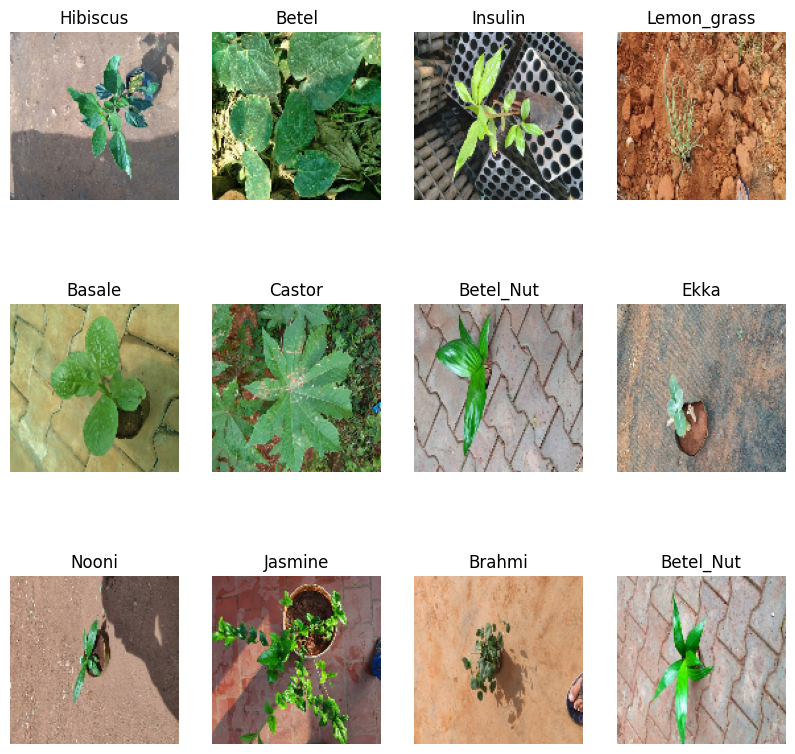

In [13]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
train_size = 0.8
len(dataset)*train_size

148.8

In [15]:
train_ds = dataset.take(172)
len(train_ds)

172

In [16]:
test_ds = dataset.skip(172)
len(test_ds)

14

In [17]:
val_size=0.1
len(dataset)*val_size

18.6

In [18]:
val_ds = test_ds.take(21)
len(val_ds)

14

In [19]:
test_ds = test_ds.skip(21)
len(test_ds)

0

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

148

In [23]:
len(val_ds)

18

In [24]:
len(test_ds)

20

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 40

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 28, 28, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [35]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
148/148 [==============================] - 23s 152ms/step - loss: 0.3676 - accuracy: 0.8700 - val_loss: 0.5044 - val_accuracy: 0.8524
Epoch 2/10
148/148 [==============================] - 24s 160ms/step - loss: 0.3968 - accuracy: 0.8676 - val_loss: 0.4162 - val_accuracy: 0.8733
Epoch 3/10
148/148 [==============================] - 23s 158ms/step - loss: 0.3491 - accuracy: 0.8788 - val_loss: 0.3667 - val_accuracy: 0.8785
Epoch 4/10
148/148 [==============================] - 24s 159ms/step - loss: 0.3625 - accuracy: 0.8776 - val_loss: 0.3352 - val_accuracy: 0.8872
Epoch 5/10
148/148 [==============================] - 28s 186ms/step - loss: 0.3095 - accuracy: 0.8892 - val_loss: 0.3719 - val_accuracy: 0.9010
Epoch 6/10
148/148 [==============================] - 26s 177ms/step - loss: 0.3722 - accuracy: 0.8708 - val_loss: 0.5671 - val_accuracy: 0.8229
Epoch 7/10
148/148 [==============================] - 27s 184ms/step - loss: 0.3298 - accuracy: 0.8881 - val_loss: 0.4092 - val_ac

In [36]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 1s 40ms/step - loss: 0.4445 - accuracy: 0.8594


In [37]:
scores

[0.44452255964279175, 0.859375]

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 148}

In [40]:
history.history

{'loss': [0.36760491132736206,
  0.3967854380607605,
  0.3490932285785675,
  0.3624695837497711,
  0.3095216453075409,
  0.3721978962421417,
  0.32984161376953125,
  0.34816911816596985,
  0.3483189046382904,
  0.3454451858997345],
 'accuracy': [0.8699513673782349,
  0.8676252961158752,
  0.8788327574729919,
  0.8775639533996582,
  0.8891943097114563,
  0.8707972168922424,
  0.8881370425224304,
  0.8811588287353516,
  0.8811588287353516,
  0.8775639533996582],
 'val_loss': [0.5043852925300598,
  0.41616928577423096,
  0.36666199564933777,
  0.3352055847644806,
  0.37194371223449707,
  0.567124605178833,
  0.40920257568359375,
  0.5337139368057251,
  0.5148510336875916,
  0.40325820446014404],
 'val_accuracy': [0.8524305820465088,
  0.8732638955116272,
  0.8784722089767456,
  0.8871527910232544,
  0.9010416865348816,
  0.8229166865348816,
  0.8680555820465088,
  0.8541666865348816,
  0.8506944179534912,
  0.8767361044883728]}

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Neem
1/1 [==============================] - 0s 69ms/step
predicted label: Neem


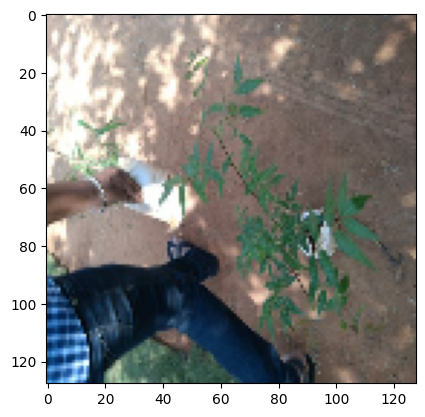

In [52]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 11ms/step


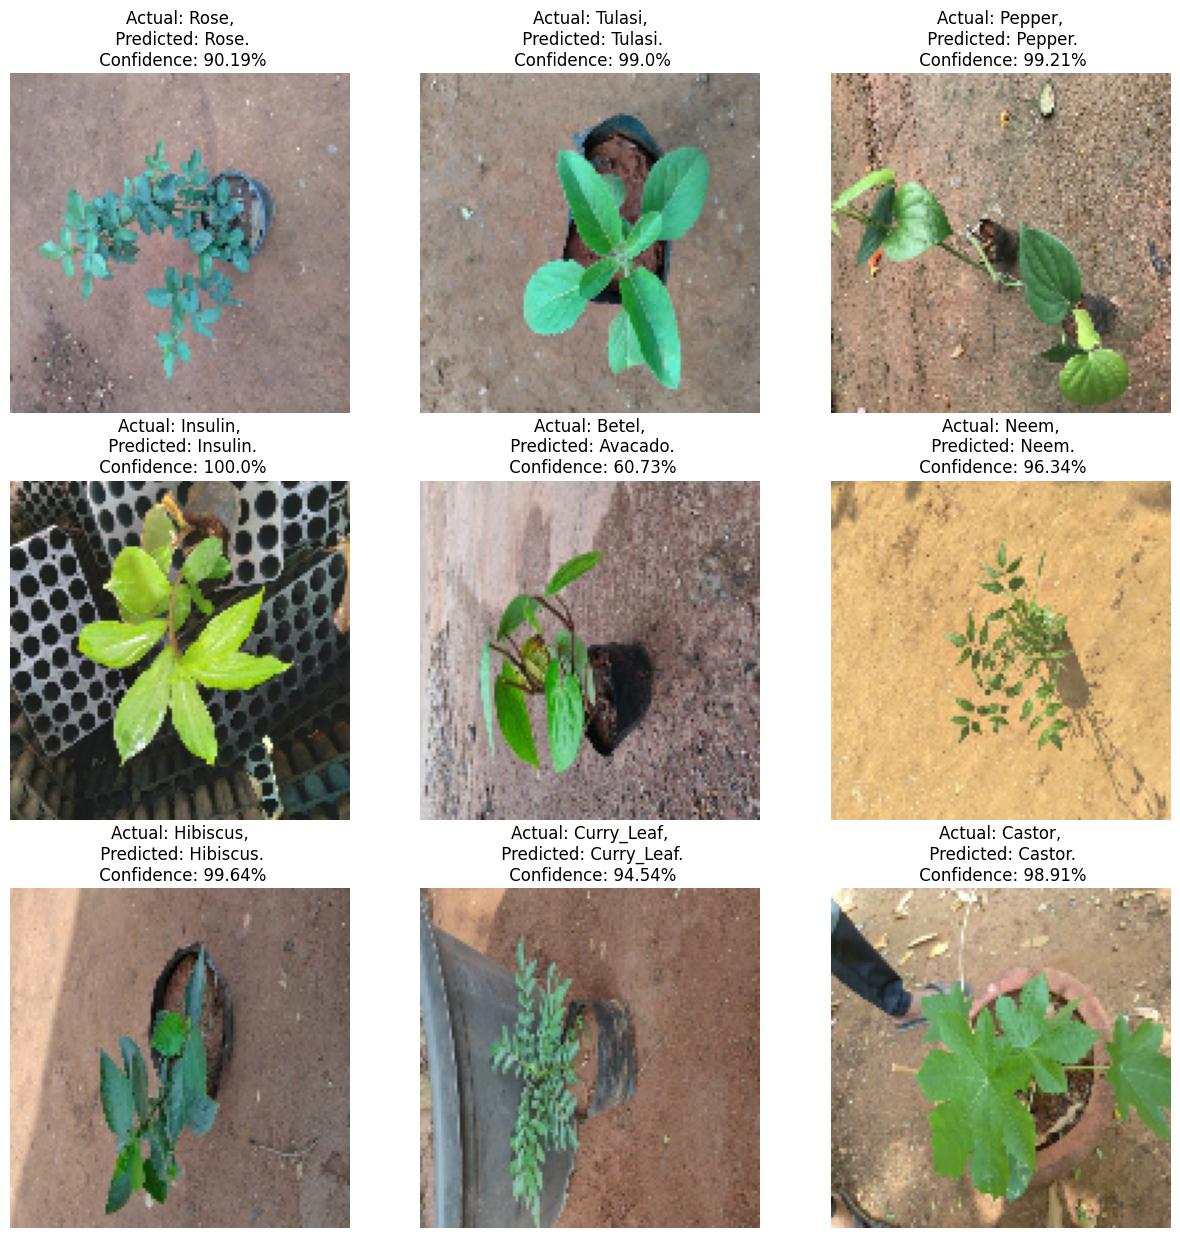

In [54]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
model_version = 1
model.save(f"../Models/{model_version}")

INFO:tensorflow:Assets written to: ../Models/1/assets


INFO:tensorflow:Assets written to: ../Models/1/assets
